In [1]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from global_land_mask import globe

In [2]:
import psutil

# Get the available memory in bytes
available_memory = psutil.virtual_memory().available
# Convert to gigabytes for easier interpretation
available_memory_gb = available_memory / (1024 ** 3)

print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 172.18 GB


In [3]:
#pip install global-land-mask

In [4]:
qa = "aerdt_aod_qa3"
FILE_AHI_agg = f"/home/svisaga/clavrx/output/nc/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_{qa}.nc"
C_AHI_agg = xarray.open_dataset(FILE_AHI_agg)
C_AHI_agg

<xarray.Dataset>
Dimensions:    (longitude: 186, latitude: 158)
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15
Data variables:
    aod_Mean   (latitude, longitude) float64 ...

In [6]:
FILE_MUSICAv0_agg = f"/home/svisaga/clavrx/output/nc/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_MUSICAv0_{qa}.nc"
C_MUSICAv0_agg = xarray.open_dataset(FILE_MUSICAv0_agg)
C_MUSICAv0_agg 


<xarray.Dataset>
Dimensions:  (lat: 158, lon: 186)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
Data variables:
    AODVIS   (lat, lon) float32 ...

In [7]:
mean_aod = C_AHI_agg['aod_Mean']
mean_aod_model = C_MUSICAv0_agg['AODVIS']

In [8]:
# Ensure NaNs in mean_aod match NaNs in mean_aod_model using a for loop
for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        value = mean_aod.sel(latitude=latitude, longitude=longitude)
        if (value < 0):
            mean_aod.loc[dict(latitude=latitude, longitude=longitude)] = np.nan
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan
        if (np.isnan(value)):
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan

In [9]:
mean_aod_model

<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.280338, 0.218502, 0.099624, ..., 0.0566  , 0.065361, 0.064997],
       [0.247699, 0.208446, 0.117989, ..., 0.061133, 0.067204, 0.0729  ],
       [0.192307, 0.104875, 0.084538, ..., 0.073471, 0.070398, 0.070519]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [10]:
mean_aod_model_ocean = mean_aod_model
mean_aod_ocean = mean_aod

for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        if not globe.is_land(latitude.item(), longitude.item()):
            mean_aod_model_ocean.loc[dict(lat=latitude, lon=longitude)] = np.nan
            mean_aod_ocean.loc[dict(latitude=latitude, longitude=longitude)] = np.nan

In [11]:
mean_aod_model_ocean

<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.280338, 0.218502, 0.099624, ...,      nan,      nan,      nan],
       [0.247699, 0.208446, 0.117989, ...,      nan,      nan,      nan],
       [0.192307, 0.104875, 0.084538, ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [12]:
mean_aod_ocean

<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.278079, 0.162147, 0.088982, ...,      nan,      nan,      nan],
       [0.165154, 0.134556, 0.113842, ...,      nan,      nan,      nan],
       [0.150985, 0.105976, 0.141481, ...,      nan,      nan,      nan]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15

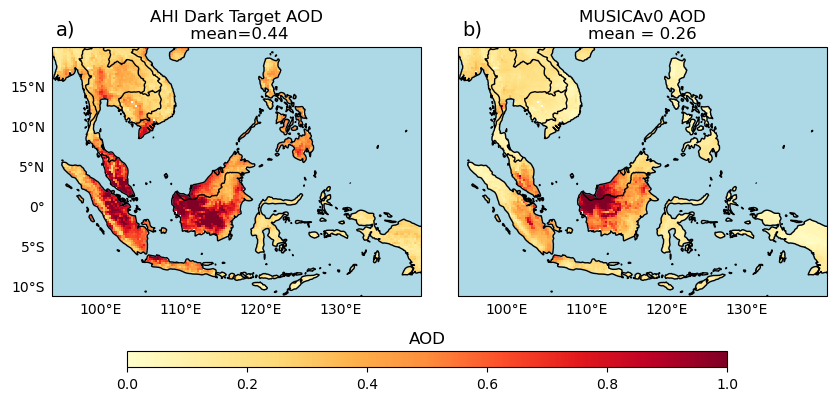

In [13]:
group_name = qa
longitude_min = 94
longitude_max = 140
latitude_min = -11  # Adjust as necessary
latitude_max = 20   # Adjust as necessary
##########################################
fig = plt.figure(figsize=(10, 8))  # Adjust the figure size for better layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1],wspace=0.1)  # Define 1 row, 2 columns

pla_proj = ccrs.PlateCarree()
ax1 = fig.add_subplot(gs[0], projection=pla_proj)
ax1.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

# Plot the mean_aod_ocean data
mean_aod_ocean.plot.pcolormesh(vmin=0, vmax=1, cmap='YlOrRd', ax=ax1, add_colorbar=False)

# Add ocean feature with a specific color
ocean = cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='lightblue')
ax1.add_feature(ocean)

ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax1.add_feature(cf.BORDERS, linewidth=1, edgecolor='black')

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False
gl.right_labels = False 
gl.top_labels = False 

ahi_mean = mean_aod_ocean.where((mean_aod_ocean.latitude >= -11) & (mean_aod_ocean >=0)).mean().item()
plt.title(f'AHI Dark Target AOD\n mean={ahi_mean:.2f}')
ax1.text(94.5, 21.5, 'a)', fontsize=14, color='black',
        transform=ccrs.PlateCarree())
########################################################################
########################################################################
########################################################################
ax2 = fig.add_subplot(gs[1], projection=pla_proj)
ax2.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

ref = mean_aod_model_ocean.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd',ax=ax2, add_colorbar=False)

ax2.add_feature(ocean)

ax2.coastlines(resolution='50m', color='black', linewidth=1)
ax2.add_feature(cf.BORDERS, linewidth=1, edgecolor='black')
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False
gl.right_labels = False 
gl.left_labels = False 
gl.top_labels = False 

musicav0_mean = mean_aod_model_ocean.where((mean_aod_model_ocean.lat >= -11) & (mean_aod_ocean >=0)).mean().item()
plt.title(f'MUSICAv0 AOD\nmean = {musicav0_mean:.2f}')
ax2.text(94.5, 21.5, 'b)', fontsize=14, color='black',
        transform=ccrs.PlateCarree())

# Create a common colorbar for both plots
cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.02])  # Adjust position as needed
plt.colorbar(ref, cax=cbar_ax, orientation='horizontal')
plt.title(f'AOD')
plt.savefig(f'img/Figure2_AMSPaper.png',dpi=300,bbox_inches='tight')

########################################################################
########################################################################
########################################################################

In [14]:
df_mean_aod_ocean = mean_aod_ocean.to_dataframe().reset_index().reset_index()
df_mean_aod_ocean

,index,latitude,longitude,aod_Mean
0,0,-19.151599,93.940236,NaN
1,1,-19.151599,94.190410,NaN
2,2,-19.151599,94.440584,NaN
3,3,-19.151599,94.690757,NaN
4,4,-19.151599,94.940931,NaN
...,...,...,...,...
29383,29383,20.152990,139.221682,NaN
29384,29384,20.152990,139.471855,NaN
29385,29385,20.152990,139.722029,NaN
29386,29386,20.152990,139.972203,NaN


In [15]:
df_mean_aod_model_ocean = mean_aod_model_ocean.to_dataframe().reset_index().reset_index()
df_mean_aod_model_ocean

,index,lat,lon,AODVIS
0,0,-19.15160,93.940239,NaN
1,1,-19.15160,94.190407,NaN
2,2,-19.15160,94.440582,NaN
3,3,-19.15160,94.690758,NaN
4,4,-19.15160,94.940933,NaN
...,...,...,...,...
29383,29383,20.15299,139.221680,NaN
29384,29384,20.15299,139.471863,NaN
29385,29385,20.15299,139.722031,NaN
29386,29386,20.15299,139.972198,NaN


In [16]:
# Merging DataFrames on latitude and longitude
merged_df_ocean = pd.merge(df_mean_aod_ocean, df_mean_aod_model_ocean, on=['index'], how='inner')
merged_df_ocean

,index,latitude,longitude,aod_Mean,lat,lon,AODVIS
0,0,-19.151599,93.940236,NaN,-19.15160,93.940239,NaN
1,1,-19.151599,94.190410,NaN,-19.15160,94.190407,NaN
2,2,-19.151599,94.440584,NaN,-19.15160,94.440582,NaN
3,3,-19.151599,94.690757,NaN,-19.15160,94.690758,NaN
4,4,-19.151599,94.940931,NaN,-19.15160,94.940933,NaN
...,...,...,...,...,...,...,...
29383,29383,20.152990,139.221682,NaN,20.15299,139.221680,NaN
29384,29384,20.152990,139.471855,NaN,20.15299,139.471863,NaN
29385,29385,20.152990,139.722029,NaN,20.15299,139.722031,NaN
29386,29386,20.152990,139.972203,NaN,20.15299,139.972198,NaN


In [17]:
merged_df_ocean_no_nan = merged_df_ocean[['index','AODVIS','aod_Mean']].dropna()
merged_df_ocean_no_nan


,index,AODVIS,aod_Mean
3288,3288,0.244286,0.118548
3289,3289,0.217672,0.112204
3290,3290,0.219980,0.122098
3291,3291,0.226097,0.116094
3292,3292,0.232461,0.123314
...,...,...,...
29247,29247,0.205346,0.337111
29248,29248,0.237553,0.415758
29249,29249,0.253487,0.575366
29250,29250,0.307114,0.664953


In [18]:
# Define bin edges
bins = np.arange(0, 2.2, 0.2)

# Bin the data and calculate the mean for each bin
merged_df_ocean_no_nan['aod_obs_bin'] = pd.cut(merged_df_ocean_no_nan['aod_Mean'], bins)
grouped_df_ocean = merged_df_ocean_no_nan.groupby('aod_obs_bin').mean()
grouped_df_ocean = grouped_df_ocean.reset_index()
grouped_df_ocean

,aod_obs_bin,index,AODVIS,aod_Mean
0,"(0.0, 0.2]",12586.268031,0.145320,0.149039
1,"(0.2, 0.4]",20733.132213,0.173093,0.290231
2,"(0.4, 0.6]",18967.967213,0.249032,0.490057
3,"(0.6, 0.8]",15326.221631,0.402409,0.688333
4,"(0.8, 1.0]",14626.707317,0.570183,0.889335
5,"(1.0, 1.2]",14447.820988,0.734185,1.087535
6,"(1.2, 1.4]",14267.454545,0.745329,1.278870
7,"(1.4, 1.6]",14394.833333,0.729259,1.476170
8,"(1.6, 1.8]",14769.000000,1.036453,1.667690
9,"(1.8, 2.0]",15312.500000,1.354690,1.899391


In [19]:
# Define bin edges
bins = np.arange(0, 2.2, 0.2)

# Bin the data and calculate the mean for each bin
grouped_df_ocean_std = merged_df_ocean_no_nan.groupby('aod_obs_bin').std()
grouped_df_ocean_std = grouped_df_ocean_std.reset_index()
grouped_df_ocean_std

,aod_obs_bin,index,AODVIS,aod_Mean
0,"(0.0, 0.2]",8672.921549,0.054389,0.035786
1,"(0.2, 0.4]",6806.835308,0.086253,0.055955
2,"(0.4, 0.6]",5610.923862,0.151011,0.057694
3,"(0.6, 0.8]",3719.169778,0.214070,0.056441
4,"(0.8, 1.0]",2105.391691,0.302369,0.059016
5,"(1.0, 1.2]",1456.506242,0.360397,0.053322
6,"(1.2, 1.4]",1017.661409,0.354442,0.058376
7,"(1.4, 1.6]",1392.080510,0.298615,0.057040
8,"(1.6, 1.8]",934.969060,0.330337,0.057948
9,"(1.8, 2.0]",263.750829,0.048448,0.051929


In [21]:
grouped_df_ocean.to_csv('output/csv/aerdt_land_mean.csv')
grouped_df_ocean_std.to_csv('output/csv/aerdt_land_std.csv')